In [28]:
import sys 
sys.path.append('../') 

In [29]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mibi_bin_tools import bin_files

### Define file parameters
 * base_dir: this is the top-level directory to store the median pulse heights for different targets
 * bin_file_path: the directory containing your bin files
 * mph_dir: the directory to save the MPH visualizations to

In [30]:
# set up directories for current run
base_dir = os.path.join('..', 'toffy', 'data')
bin_file_path = os.path.join(base_dir, 'tissue')
mph_dir = os.path.join(base_dir, 'tissue_mph')
#mph_dir = os.path.join('C:\\Users\\Customer.ION\\Documents\\qc_metrics', 'tissue')

# make mph_dir if it doesn't exist
if not os.path.exists(mph_dir):
    os.makedirs(mph_dir)

In [31]:
# define which channel to retrieve data for
target = 'CD8'

# retrieve the total counts and compute pulse heights for each FOV run file
# saves individual .csv  files to bin_file_path
total_counts = bin_files.get_total_counts(bin_file_path)

for i in range(1, len(total_counts)+1): 
    pulse_height_file = 'fov-{}-pulse_height.csv'.format(i)
    
    if os.path.exists(os.path.join(bin_file_path, pulse_height_file)):
        pass
    else:
        print(f'\r{i}...', end='')
        median = bin_files.get_median_pulse_height(bin_file_path, 'fov-{}-scan-1'.format(i) , target)
        count = total_counts['fov-{}-scan-1'.format(i)]

        out_df = pd.DataFrame({
            'fov': [i],
            'MPH': [median],
            'total_count': [count]})
        out_df.to_csv(os.path.join(bin_file_path, pulse_height_file), index=False)

### Visualize MPH Plots

In [32]:
# prior to generating the graphs, need to combine the data for each FOV into one combined .csv
# saves directly to mph_dir
pulse_heights = []
fov_counts = []

for i in range(1, len(total_counts)+1):
    temp_df = pd.read_csv(os.path.join(bin_file_path, 'fov-{}-pulse_height.csv'.format(i)))
    pulse_heights.append(temp_df['MPH'].values[0])
    if i>1:
        fov_counts.append(temp_df['total_count'].values[0] + fov_counts[i-2])
    else:
        fov_counts.append(temp_df['total_count'].values[0])
                           
combined_df = pd.DataFrame({'pulse_heights': pulse_heights, 'cum_total_count': fov_counts})
combined_df.to_csv(os.path.join(mph_dir, 'total_count_vs_mph_data.csv'), index=False)

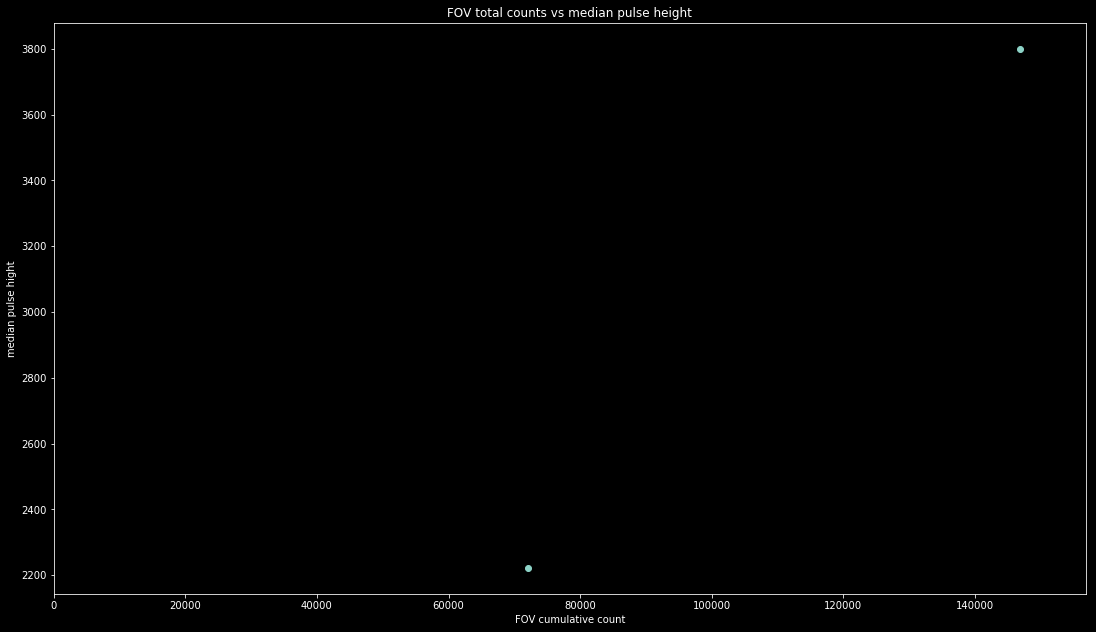

In [33]:
# visualize the median pulse heights
plt.style.use('dark_background')
plt.title('FOV total counts vs median pulse height')
plt.scatter(fov_counts, pulse_heights)
plt.gca().set_xlabel('FOV cumulative count')
plt.gca().set_ylabel('median pulse hight')
plt.gcf().set_size_inches(18.5, 10.5)
plt.xlim(0, max(fov_counts)+10000)

# save plot to mph_dir
plt.savefig(os.path.join(mph_dir, 'fov_vs_mph.jpg'))